In [1]:
!pip install keras-tuner --upgrade

   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   --------- ------------------------------ 30.7/129.1 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 129.1/129.1 kB 2.5 MB/s eta 0:00:00


DEPRECATION: lightning-lite 1.8.0 has a non-standard dependency specifier torch>=1.9.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of lightning-lite or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [3]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
plt.rcParams['figure.figsize'] = [20, 6]

import random

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [4]:
# Importing the dataset
df= pd.read_csv('dataset.csv', encoding='latin1')
df

,numer_sta,date,lat,lon,Temperature,Humidity,Wind speed,Pressure,Wave height,Wave period,Storm,storm name
0,62163,1/1/1996,47.5,-8.5,285.249334,87.471219,6.931818,99436.48589,4.336735,9.494752,0,NaN
1,62163,1/2/1996,47.5,-8.5,286.219464,88.826087,7.457478,101116.52170,3.452174,8.236621,0,NaN
2,62163,1/3/1996,47.5,-8.5,286.628267,89.209170,11.875000,100714.26900,4.400000,7.744227,0,NaN
3,62163,1/4/1996,47.5,-8.5,285.677647,88.564218,7.670588,99640.00000,3.805882,8.000000,0,NaN
4,62163,1/5/1996,47.5,-8.5,285.065882,83.692654,10.820235,99380.31641,4.571069,8.052032,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9127,62163,12/27/2020,47.5,-8.5,283.741667,77.500000,21.475000,99274.58333,8.400000,10.083333,1,bella
9128,62163,12/28/2020,47.5,-8.5,283.783333,71.750000,21.462500,99166.25000,9.454167,11.083333,1,bella
9129,62163,12/29/2020,47.5,-8.5,282.641667,66.583333,13.387500,100402.91670,6.312500,9.000000,0,NaN
9130,62163,12/30/2020,47.5,-8.5,283.770833,79.291667,9.808333,101017.08330,3.450000,7.000000,0,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9132 entries, 0 to 9131
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   numer_sta    9132 non-null   int64  
 1   date         9132 non-null   object 
 2   lat          9132 non-null   float64
 3   lon          9132 non-null   float64
 4   Temperature  9036 non-null   float64
 5   Humidity     9035 non-null   float64
 6   Wind speed   9045 non-null   float64
 7   Pressure     9058 non-null   float64
 8   Wave height  9038 non-null   float64
 9   Wave period  9006 non-null   float64
 10  Storm        9132 non-null   int64  
 11  storm name   21 non-null     object 
dtypes: float64(8), int64(2), object(2)
memory usage: 856.2+ KB


In [6]:
df = df.drop(['numer_sta', 'lat', 'lon', 'storm name', 'Storm'], axis=1)
df.head()

,date,Temperature,Humidity,Wind speed,Pressure,Wave height,Wave period
0,1/1/1996,285.249334,87.471219,6.931818,99436.48589,4.336735,9.494752
1,1/2/1996,286.219464,88.826087,7.457478,101116.52170,3.452174,8.236621
2,1/3/1996,286.628267,89.209170,11.875000,100714.26900,4.400000,7.744227
3,1/4/1996,285.677647,88.564218,7.670588,99640.00000,3.805882,8.000000
4,1/5/1996,285.065882,83.692654,10.820235,99380.31641,4.571069,8.052032


In [7]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index("date")

In [8]:
# Dealing with missing values
print(df.isnull().sum())

Temperature     96
Humidity        97
Wind speed      87
Pressure        74
Wave height     94
Wave period    126
dtype: int64


In [9]:
from sklearn.impute import SimpleImputer

# Create an imputer object using median as the strategy
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Define the columns where you want to apply the imputation
columns_to_impute = ['Temperature',	'Humidity',	'Wind speed',	'Pressure', 'Wave height', 'Wave period']

# Apply the imputer to the selected columns of the DataFrame
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

# Checking the DataFrame to ensure no more missing values
df.isnull().values.any()

False

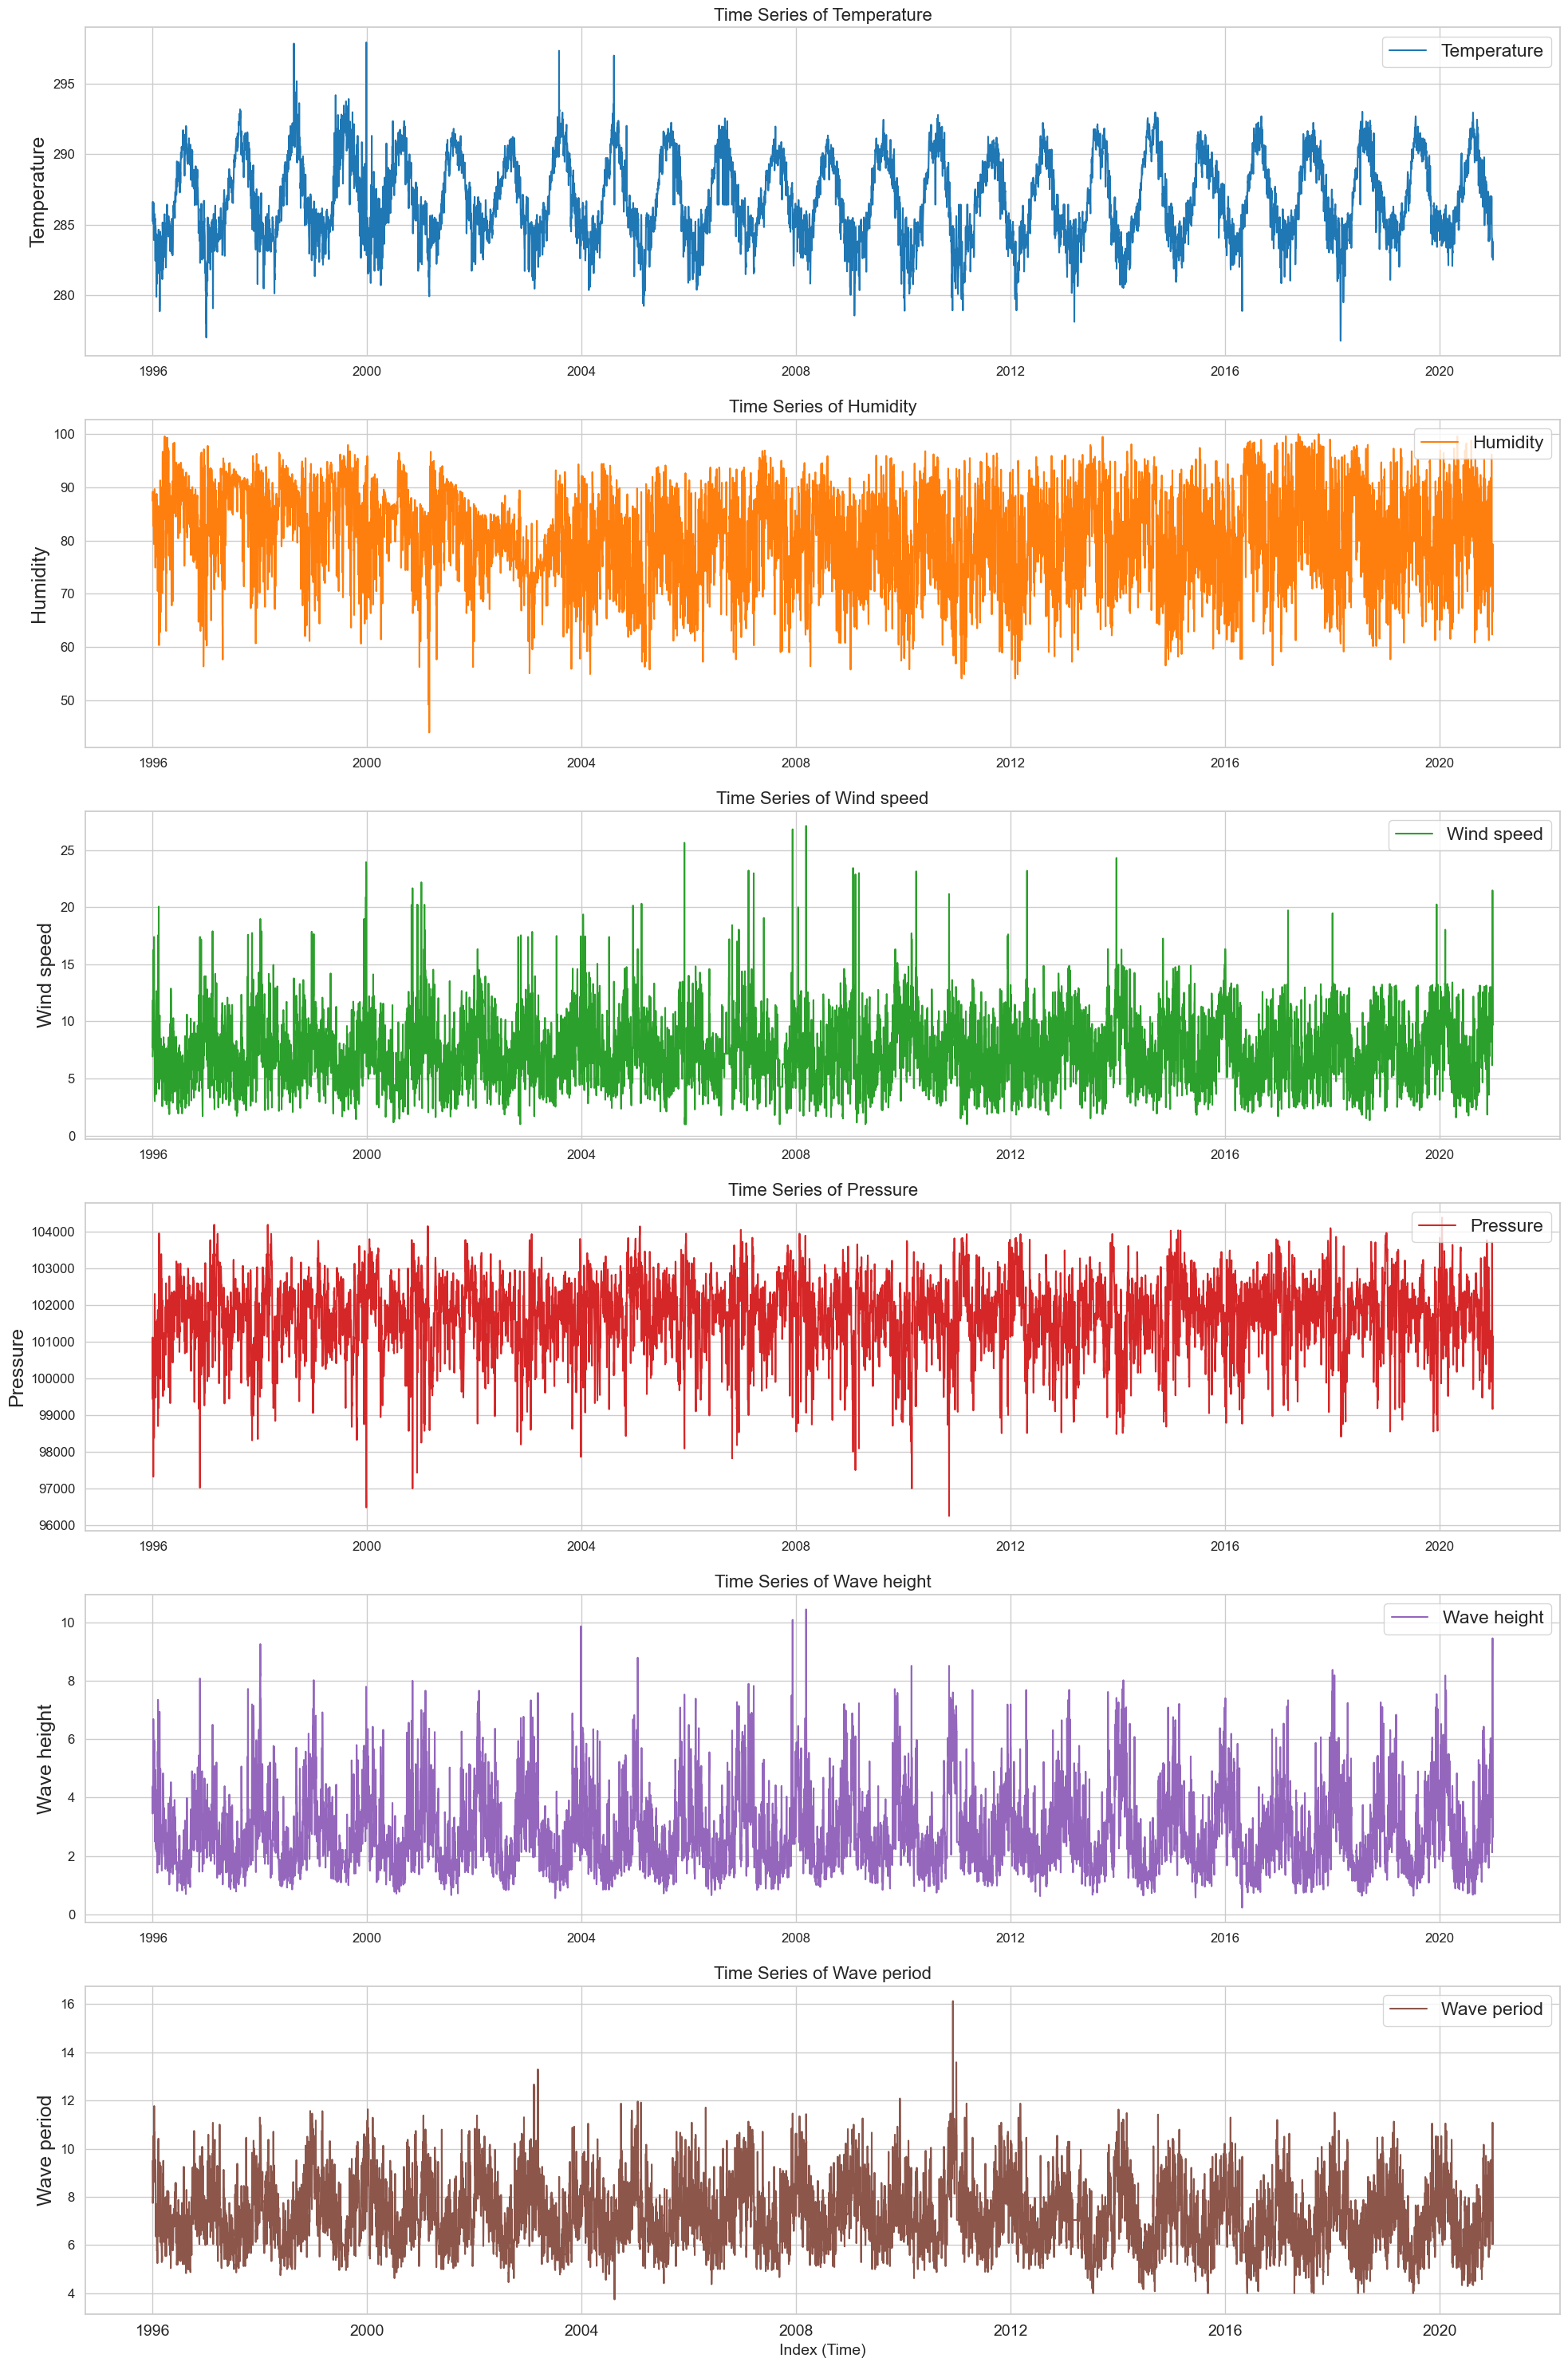

In [10]:
num_variables = len(df.columns)
fig, axes = plt.subplots(nrows=num_variables, ncols=1, figsize=(20, 5 * num_variables))

# Plot each variable on its own subplot
for i, column in enumerate(df.columns):
    axes[i].plot(df.index, df[column], label=f'{column}', color=plt.cm.tab10(i))
    axes[i].set_title(f'Time Series of {column}', fontsize=16)
    axes[i].legend(loc='upper right')
    axes[i].set_ylabel(column)
    axes[i].tick_params(labelsize=12)

# Set common labels
plt.xlabel("Index (Time)", fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

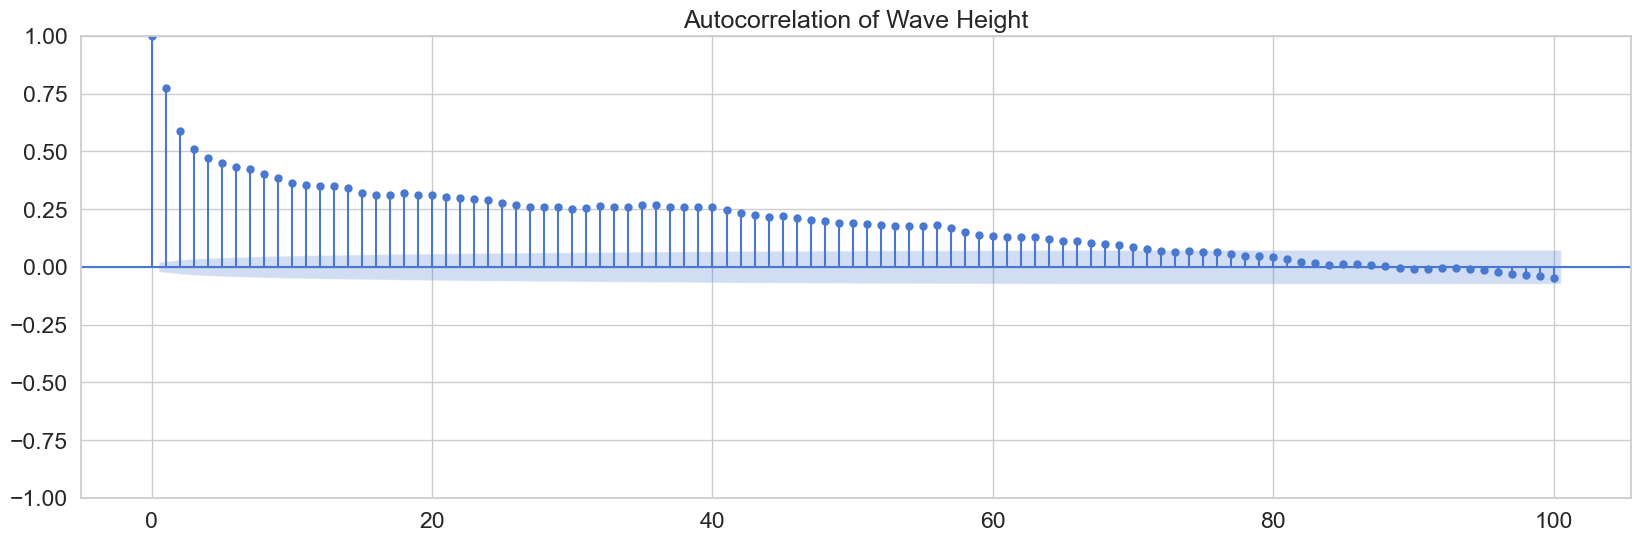

<Figure size 1400x700 with 0 Axes>

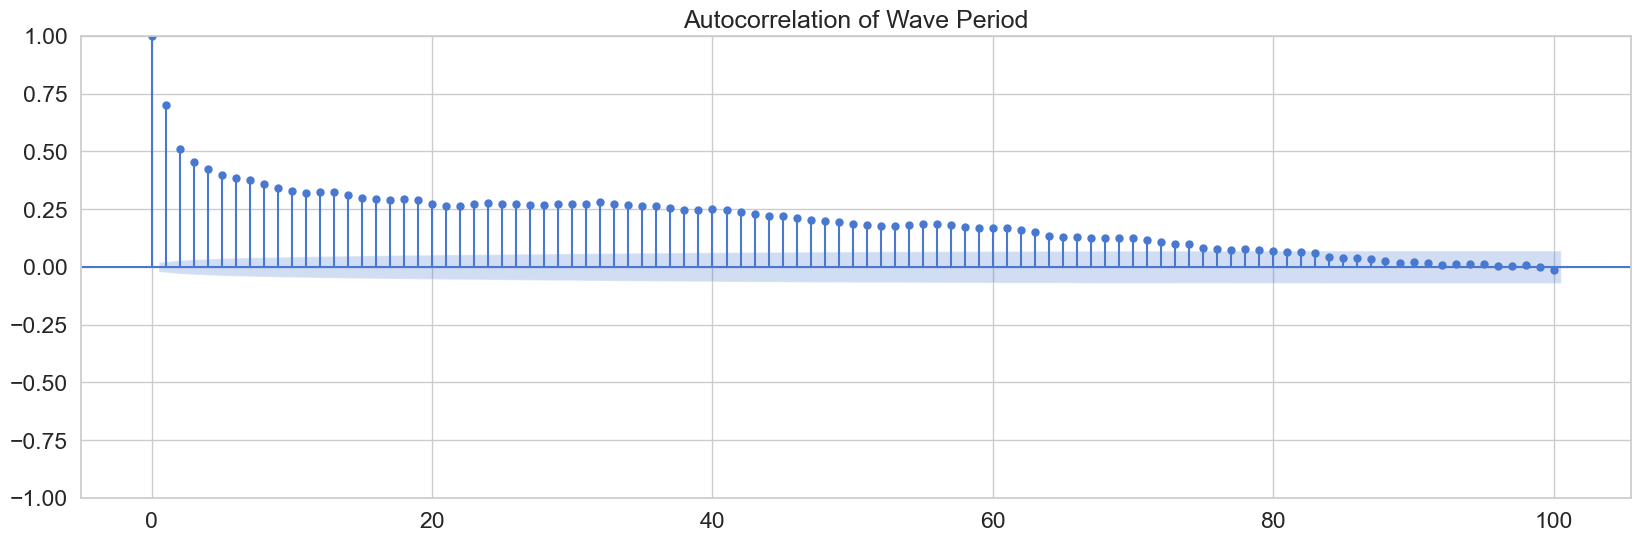

<Figure size 1400x700 with 0 Axes>

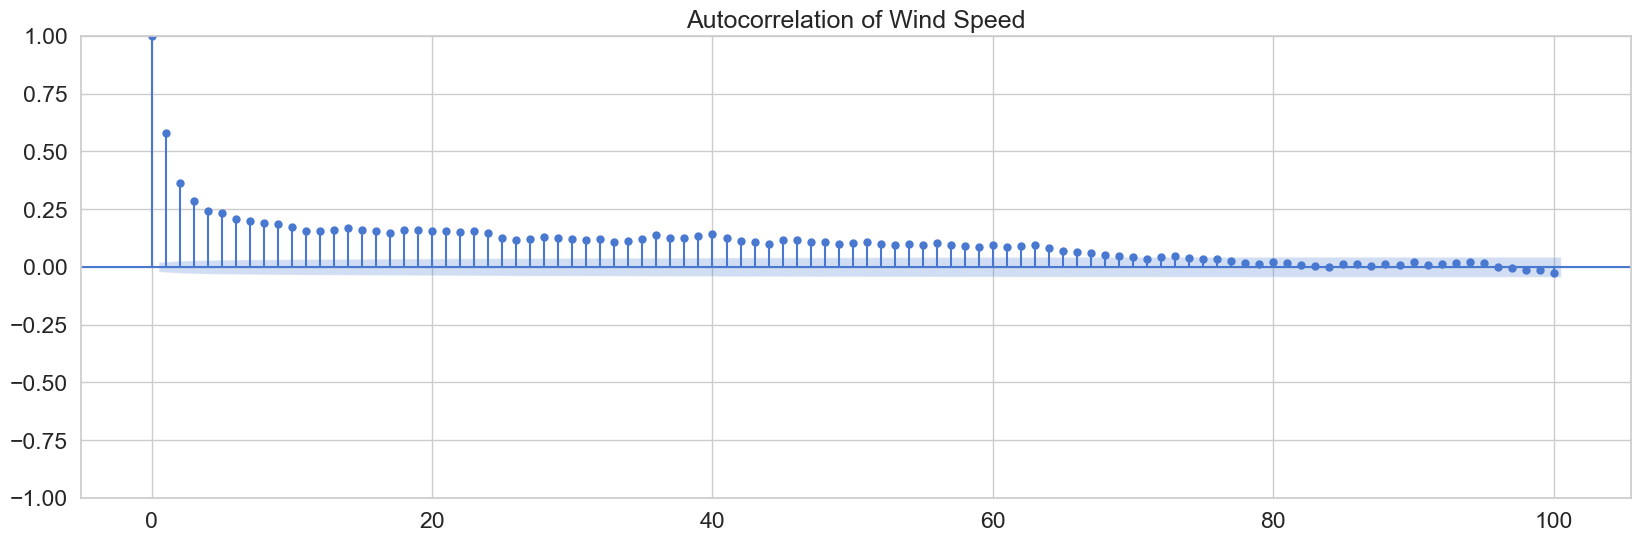

<Figure size 1400x700 with 0 Axes>

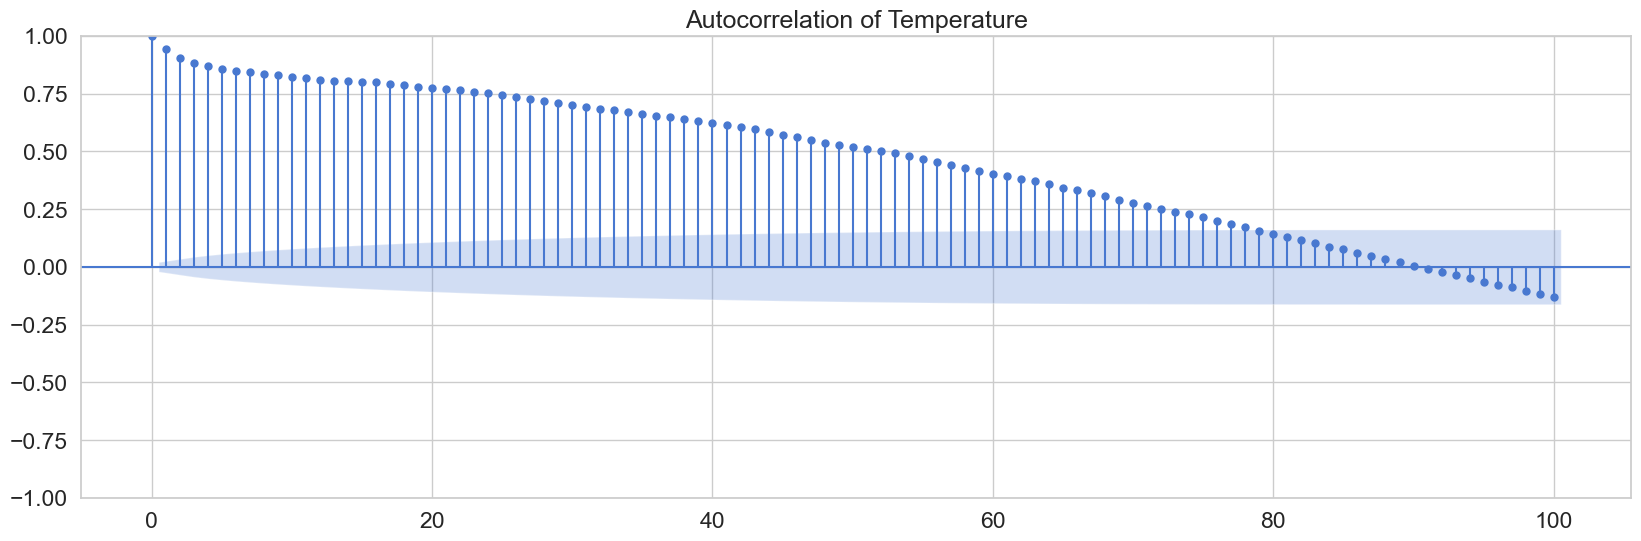

<Figure size 1400x700 with 0 Axes>

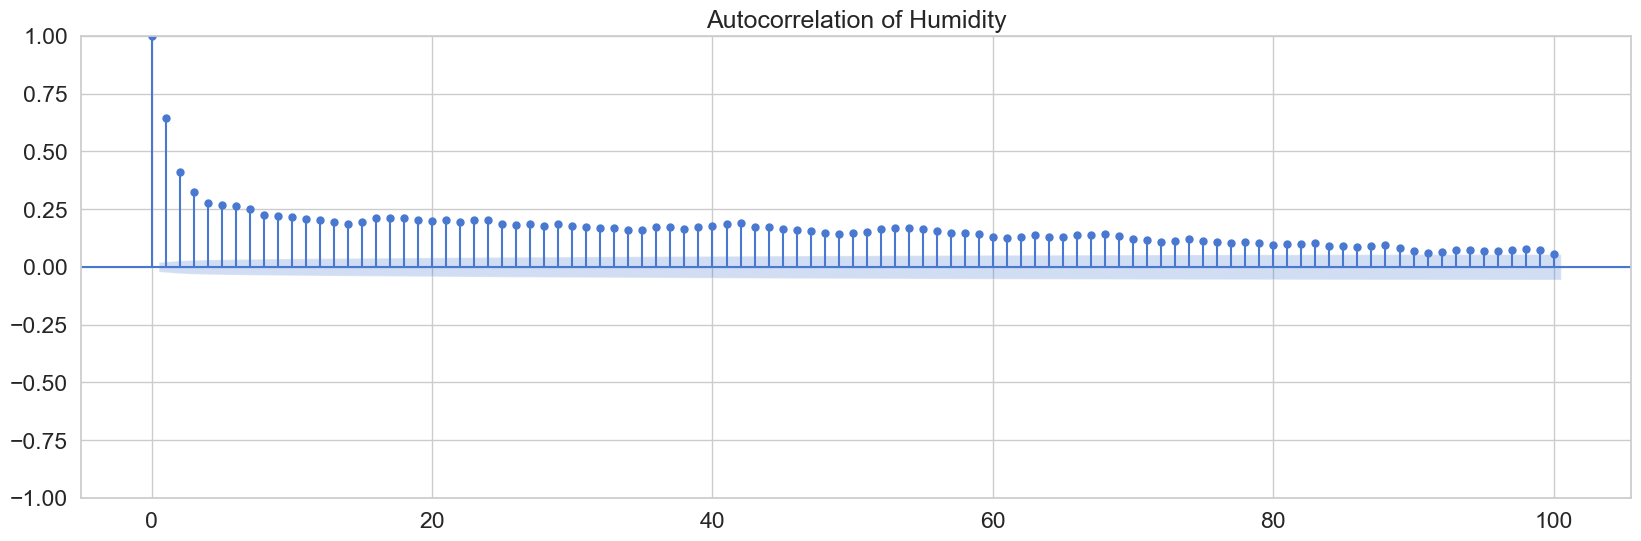

<Figure size 1400x700 with 0 Axes>

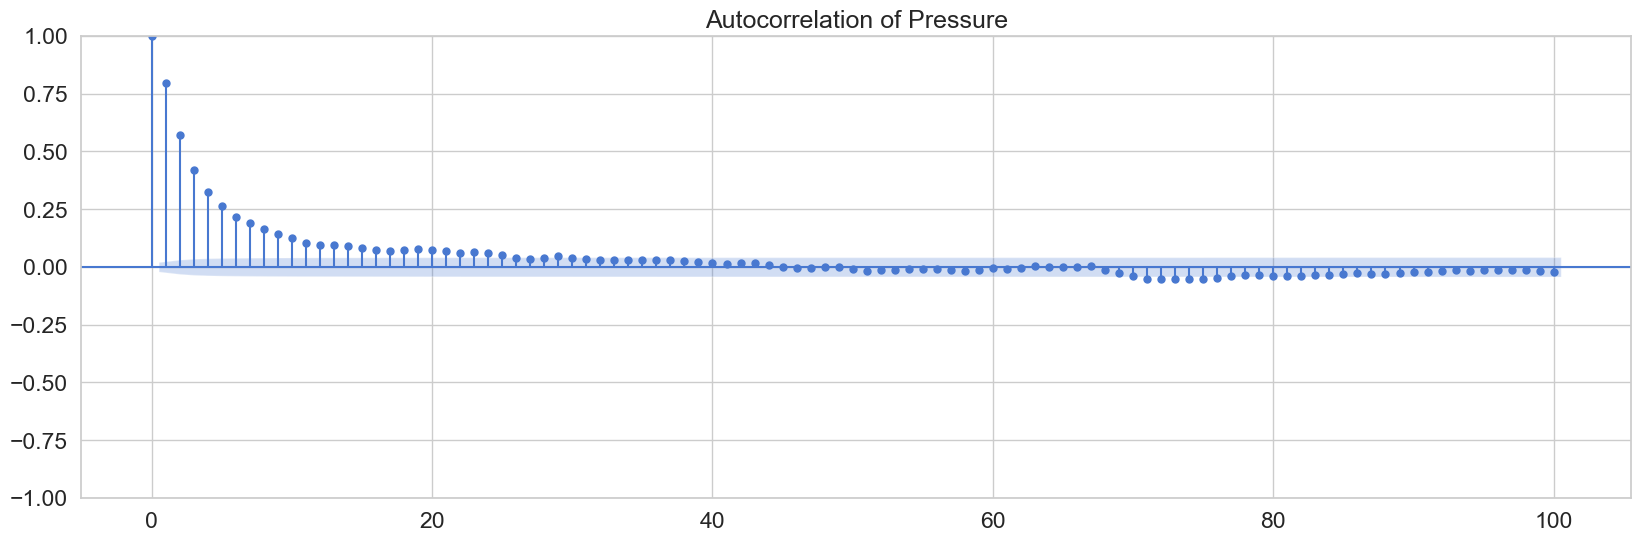

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

wave_height = df['Wave height']

# Plot the ACF
plt.figure(figsize=(14,7))
plot_acf(wave_height, lags=100, alpha=0.05)
plt.title('Autocorrelation of Wave Height')
plt.show()

wave_period = df['Wave period']

# Plot the ACF
plt.figure(figsize=(14,7))
plot_acf(wave_period, lags=100, alpha=0.05)
plt.title('Autocorrelation of Wave Period')
plt.show()


Wind_speed = df['Wind speed']

# Plot the ACF
plt.figure(figsize=(14,7))
plot_acf(Wind_speed, lags=100, alpha=0.05)
plt.title('Autocorrelation of Wind Speed')
plt.show()

temperature = df['Temperature']
# Plot the ACF
plt.figure(figsize=(14,7))
plot_acf(temperature, lags=100, alpha=0.05)
plt.title('Autocorrelation of Temperature')
plt.show()

humidity = df['Humidity']
# Plot the ACF
plt.figure(figsize=(14,7))
plot_acf(humidity, lags=100, alpha=0.05)
plt.title('Autocorrelation of Humidity')
plt.show()

pressure = df['Pressure']
# Plot the ACF
plt.figure(figsize=(14,7))
plot_acf(pressure, lags=100, alpha=0.05)
plt.title('Autocorrelation of Pressure')
plt.show()

In [12]:
# Data Formating/ Preparing the input shape

def df_to_X_y(df_1, window_size=30):
  df_as_np = df_1.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1], df_as_np[i+window_size][2], df_as_np[i+window_size][3], df_as_np[i+window_size][4], df_as_np[i+window_size][5]]
    y.append(label)
  return np.array(X), np.array(y)

In [13]:
X, y = df_to_X_y(df)
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (9102, 30, 6)
Shape of y: (9102, 6)


In [14]:
# Define the size of the training set
train_size = int(len(X) * 0.80)  # Using 80% of data for training and 20% for testing

# Split the data into training and test sets by slicing
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Print the shapes to verify the split
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7281, 30, 6)
y_train shape: (7281, 6)
X_test shape: (1821, 30, 6)
y_test shape: (1821, 6)


In [15]:
# Normalization
temp_training_mean = np.mean(X_train[:, :, 0])
temp_training_std = np.std(X_train[:, :, 0])

hum_training_mean = np.mean(X_train[:, :, 1])
hum_training_std = np.std(X_train[:, :, 1])

wind_training_mean = np.mean(X_train[:, :, 2])
wind_training_std = np.std(X_train[:, :, 2])

pres_training_mean = np.mean(X_train[:, :, 3])
pres_training_std = np.std(X_train[:, :, 3])

waveH_training_mean = np.mean(X_train[:, :, 4])
waveH_training_std = np.std(X_train[:, :, 4])

waveP_training_mean = np.mean(X_train[:, :, 5])
waveP_training_std = np.std(X_train[:, :, 5])

def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  X[:, :, 1] = (X[:, :, 1] - hum_training_mean) / hum_training_std
  X[:, :, 2] = (X[:, :, 2] - wind_training_mean) / wind_training_std
  X[:, :, 3] = (X[:, :, 3] - pres_training_mean) / pres_training_std
  X[:, :, 4] = (X[:, :, 4] - waveH_training_mean) / waveH_training_std
  X[:, :, 5] = (X[:, :, 5] - waveP_training_mean) / waveP_training_std

def preprocess_output(y):
  y[:, 0] = (y[:, 0] - temp_training_mean) / temp_training_std
  y[:, 1] = (y[:, 1] - hum_training_mean) / hum_training_std
  y[:, 2] = (y[:, 2] - wind_training_mean) / wind_training_std
  y[:, 3] = (y[:, 3] - pres_training_mean) / pres_training_std
  y[:, 4] = (y[:, 4] - waveH_training_mean) / waveH_training_std
  y[:, 5] = (y[:, 5] - waveP_training_mean) / waveP_training_std
  return y

In [16]:
preprocess(X_train)
preprocess(X_test)

In [17]:
preprocess_output(y_train)
preprocess_output(y_test)

array([[-0.64343101, -0.71690681,  0.32804475, -1.83695668,  1.4801014 ,
         0.55733682],
       [-0.92048736, -0.83499513,  1.12708326, -0.78730262,  0.53639186,
         1.70724395],
       [-1.13438059, -0.98260553,  1.1228704 , -2.92933412,  1.38480825,
         0.98098681],
       ...,
       [-1.41717902, -1.64685232,  1.99352747, -1.3054279 ,  2.59287943,
         1.25333324],
       [-1.02815174, -0.1461466 ,  0.78724614, -0.68803366,  0.48106035,
        -0.19918104],
       [-1.46311584, -1.49924192,  0.752139  , -0.55986361, -0.10606838,
        -0.89517746]])

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import BayesianOptimization, Objective
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit



class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32),return_sequences=True, input_shape=(30,6)))
        for i in range(hp.Int('n_layers', 1, 4)):
          model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=512,step=32),return_sequences=True))
        model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=32)))
        model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
        model.add(Dense(6, activation='linear'))
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
            loss='mean_absolute_error',
            metrics=['mean_absolute_error'])
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32, 64, 128]),
            **kwargs,
        )

tuner = kt.BayesianOptimization(
    MyHyperModel(),
    objective="val_mean_absolute_error",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="tune_hypermodel",
)

early_stopping_monitor = EarlyStopping(
    monitor='val_mean_absolute_error',
    patience=40,
    min_delta=0.001,
    restore_best_weights=True,
    verbose=1
)


def cross_validate(X, y, n_splits=3):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, val_index in tscv.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        tuner.search(
            X_train_fold, y_train_fold, epochs=10,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=[early_stopping_monitor]
        )


# Call to perform cross-validation
cross_validate(X_train, y_train, n_splits=3)

Trial 10 Complete [00h 04m 13s]
val_mean_absolute_error: 0.6591187715530396

Best val_mean_absolute_error So Far: 0.5802317559719086
Total elapsed time: 00h 27m 01s


In [20]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("The best hyperparameters are:")
print(f"Input LSTM units: {best_hps.get('input_unit')}")
print(f"Number of LSTM layers: {best_hps.get('n_layers') + 2}")  # includes input and final LSTM layers
for i in range(best_hps.get('n_layers')):
    print(f"LSTM units in layer {i+1}: {best_hps.get(f'lstm_{i}_units')}")
print(f"Final LSTM layer units: {best_hps.get('layer_2_neurons')}")
print(f"Dropout rate: {best_hps.get('Dropout_rate')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")
print(f"Batch size: {best_hps.get('batch_size')}")

The best hyperparameters are:
Input LSTM units: 352
Number of LSTM layers: 3
LSTM units in layer 1: 352
Final LSTM layer units: 128
Dropout rate: 0.0
Learning rate: 0.001
Batch size: 128


In [22]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Training the model with the full training dataset
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=best_hps.get('batch_size'),
    callbacks=[early_stopping_monitor]
)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 252ms/step - loss: 0.6577 - mean_absolute_error: 0.6577
Epoch 2/10


c:\Users\suzan\anaconda3\envs\tseries4\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_mean_absolute_error` which is not available. Available metrics are: loss,mean_absolute_error
  current = self.get_monitor_value(logs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 253ms/step - loss: 0.5848 - mean_absolute_error: 0.5848
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 257ms/step - loss: 0.5210 - mean_absolute_error: 0.5210
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 274ms/step - loss: 0.4653 - mean_absolute_error: 0.4653
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 276ms/step - loss: 0.4468 - mean_absolute_error: 0.4468
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 271ms/step - loss: 0.4376 - mean_absolute_error: 0.4376
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 271ms/step - loss: 0.4321 - mean_absolute_error: 0.4321
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 272ms/step - loss: 0.4292 - mean_absolute_error: 0.4292
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 275ms/step - loss: 0.4260 - mean_absolute_error: 0.4260
Epoch 10/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 274ms/step - loss: 0.4229 - mean_absolute_error: 0.4229


In [23]:
# Predicting on unseen data
predictions = model.predict(X_test)

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step


In [24]:
temp_preds, hum_preds, wind_preds, pres_preds, waveH_preds, waveP_preds = predictions[:, 0], predictions[:, 1], predictions[:, 2], predictions[:, 3], predictions[:, 4], predictions[:, 5]
temp_actuals, hum_actuals, wind_actuals, pres_actuals, waveH_actuals, waveP_actuals = y_test[:, 0], y_test[:, 1], y_test[:, 2], y_test[:, 3], y_test[:, 4], y_test[:, 5]

df_prediction = pd.DataFrame(data={'Temperature Predictions': temp_preds, 'Temperature Actuals':temp_actuals,
                                   'Humidity Predictions': hum_preds, 'Humidity Actuals':hum_actuals,
                                   'Wind speed Predictions': wind_preds, 'Wind speed Actuals': wind_actuals,
                                   'Pressure Predictions': pres_preds, 'Pressure Actuals': pres_actuals,
                                   'Wave height Predictions': waveH_preds, 'Wave height Actuals': waveH_actuals,
                                   'Wave period Predictions': waveP_preds, 'Wave period Actuals': waveP_actuals,

                          })

In [25]:
df_prediction.head()

,Temperature Predictions,Temperature Actuals,Humidity Predictions,Humidity Actuals,Wind speed Predictions,Wind speed Actuals,Pressure Predictions,Pressure Actuals,Wave height Predictions,Wave height Actuals,Wave period Predictions,Wave period Actuals
0,-1.004586,-0.643431,-1.203369,-0.716907,1.057555,0.328045,-1.273028,-1.836957,1.196423,1.480101,0.884739,0.557337
1,-0.593663,-0.920487,-0.428423,-0.834995,1.277476,1.127083,-2.027930,-0.787303,1.781283,0.536392,1.304260,1.707244
2,-0.918161,-1.134381,-0.891404,-0.982606,0.972867,1.122870,-0.534812,-2.929334,0.563689,1.384808,0.230830,0.980987
3,-1.270062,-0.891777,-1.073418,-1.317189,1.475987,0.957165,-2.458323,-1.268987,2.190279,0.892973,1.346139,0.527076
4,-0.734204,-1.174575,-0.475753,-1.897790,0.876155,0.826566,-0.825013,-0.101216,0.602977,0.942156,0.601237,0.436294


In [26]:
def postprocess_temp(arr):
  arr = (arr*temp_training_std) + temp_training_mean
  return arr

def postprocess_hum(arr):
  arr = (arr*hum_training_std) + hum_training_mean
  return arr

def postprocess_wind(arr):
  arr = (arr*wind_training_std) + wind_training_mean
  return arr

def postprocess_pres(arr):
  arr = (arr*pres_training_std) + pres_training_mean
  return arr

def postprocess_waveH(arr):
  arr = (arr*waveH_training_std) + waveH_training_mean
  return arr

def postprocess_waveP(arr):
  arr = (arr*waveP_training_std) + waveP_training_mean
  return arr

In [27]:
temp_preds1, hum_preds1, wind_preds1, pres_preds1, waveH_preds1, waveP_preds1  = postprocess_temp(predictions[:, 0]), postprocess_hum(predictions[:, 1]), postprocess_wind(predictions[:, 2]), postprocess_pres(predictions[:, 3]), postprocess_waveH(predictions[:, 4]), postprocess_waveP(predictions[:, 5])

temp_actuals1, hum_actuals1, wind_actuals1, pres_actuals1, waveH_actuals1, waveP_actuals1 = postprocess_temp(y_test[:, 0]), postprocess_hum(y_test[:, 1]), postprocess_wind(y_test[:, 2]), postprocess_pres(y_test[:, 3]), postprocess_waveH(y_test[:, 4]), postprocess_waveP(y_test[:, 5])


df_prediction1 = pd.DataFrame(data={'Temperature Predictions': temp_preds1, 'Temperature Actuals':temp_actuals1,
                                   'Humidity Predictions': hum_preds1, 'Humidity Actuals':hum_actuals1,
                                   'Wind speed Predictions': wind_preds1, 'Wind speed Actuals': wind_actuals1,
                                   'Pressure Predictions': pres_preds1, 'Pressure Actuals': pres_actuals1,
                                   'Wave height Predictions': waveH_preds1, 'Wave height Actuals': waveH_actuals1,
                                    'Wave period Predictions': waveP_preds1, 'Wave period Actuals': waveP_actuals1
                          })

In [28]:
df_prediction1

,Temperature Predictions,Temperature Actuals,Humidity Predictions,Humidity Actuals,Wind speed Predictions,Wind speed Actuals,Pressure Predictions,Pressure Actuals,Wave height Predictions,Wave height Actuals,Wave period Predictions,Wave period Actuals
0,283.839233,284.887500,70.338860,74.458333,10.610369,8.445833,100435.148438,99874.16667,4.419650,4.804167,8.492474,8.041667
1,285.031982,284.083333,76.901283,73.458333,11.262899,10.816667,99684.195312,100918.33330,5.212408,3.525000,9.070123,9.625000
2,284.090088,283.462500,72.980652,72.208333,10.359090,10.804167,101169.507812,98787.50000,3.562001,4.675000,7.592091,8.625000
3,283.068695,284.166667,71.439316,69.375000,11.851902,10.312500,99256.054688,100439.16670,5.766789,4.008333,9.127786,8.000000
4,284.624054,283.345833,76.500481,64.458333,10.072137,9.925000,100880.820312,101600.83330,3.615254,4.075000,8.102113,7.875000
...,...,...,...,...,...,...,...,...,...,...,...,...
1816,283.942291,283.741667,75.384827,77.500000,9.616921,21.475000,102310.109375,99274.58333,2.789875,8.400000,6.250886,10.083333
1817,283.384796,283.783333,71.923965,71.750000,12.014787,21.462500,100800.984375,99166.25000,5.781075,9.454167,8.721856,11.083333
1818,283.773712,282.641667,74.978760,66.583333,12.482048,13.387500,100741.726562,100402.91670,5.886954,6.312500,9.493461,9.000000
1819,282.406281,283.770833,68.515182,79.291667,9.644264,9.808333,101519.195312,101017.08330,3.519456,3.450000,8.233892,7.000000


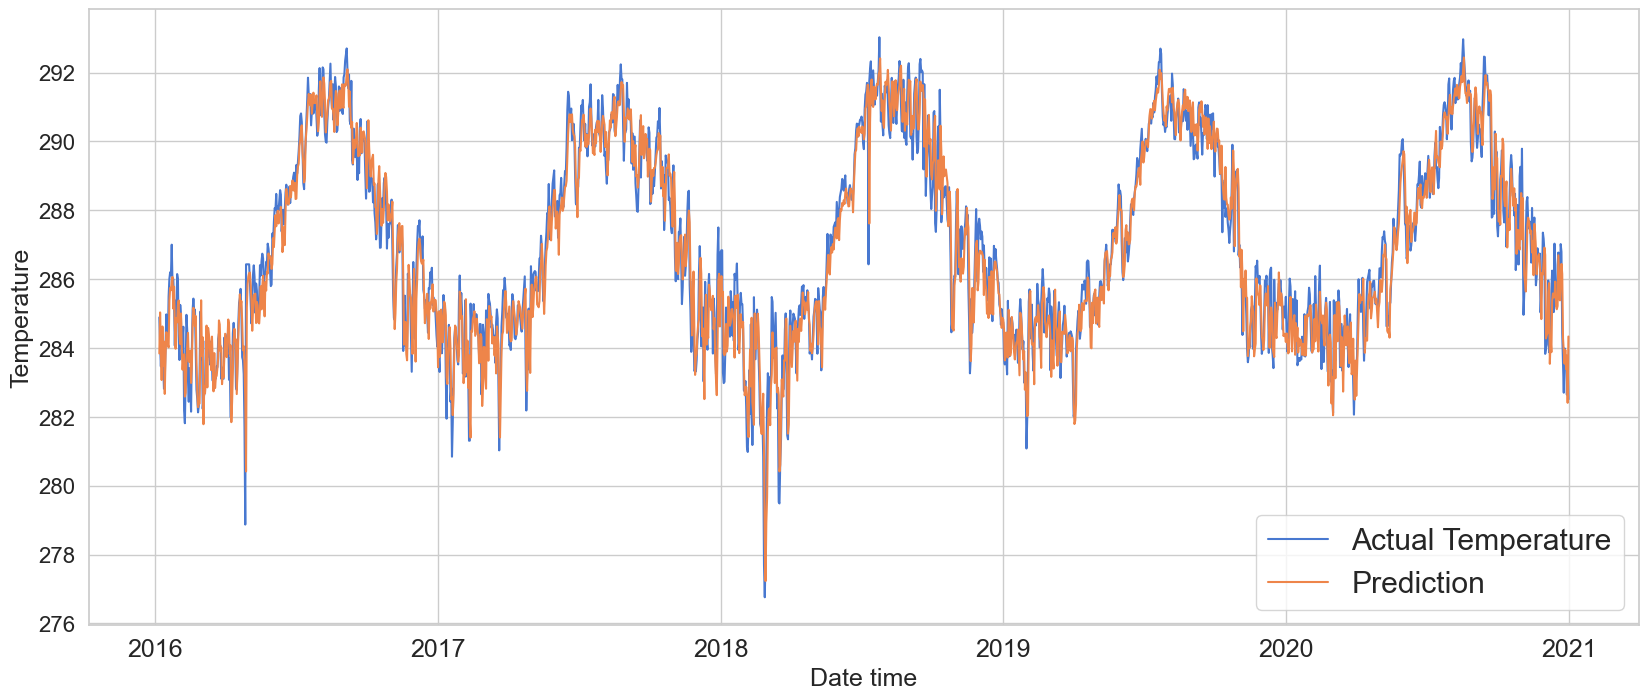

In [29]:
# Temperature prediction
plt.figure(figsize=(20, 8))
plt.plot(df[7311:].index, df_prediction1['Temperature Actuals'], label="Actual Temperature")
plt.plot(df[7311:].index, df_prediction1['Temperature Predictions'], label="Prediction")
plt.legend(loc='best', fontsize='large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel("Date time")
plt.ylabel("Temperature")
plt.show()

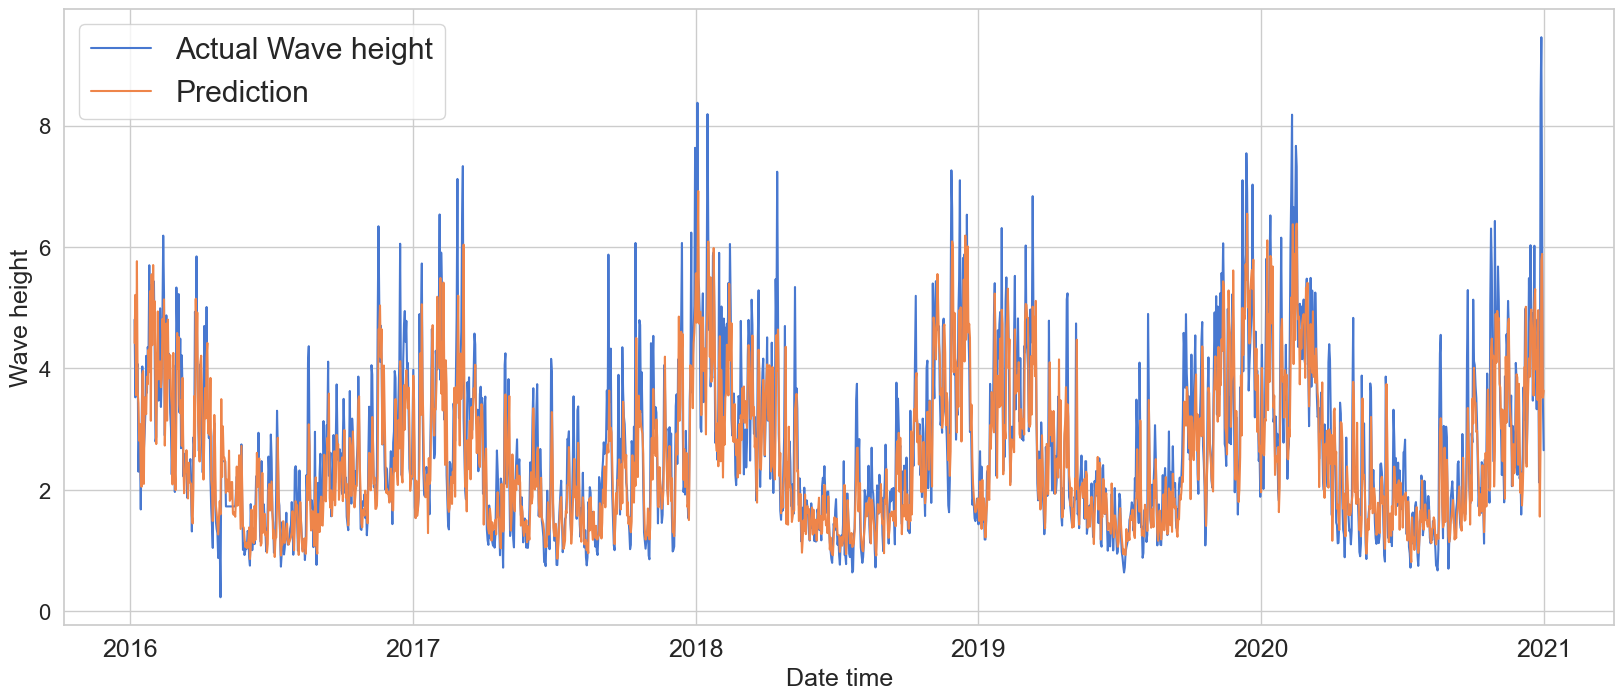

In [30]:
# Wave height prediction
plt.figure(figsize=(20, 8))
plt.plot(df[7311:].index, df_prediction1['Wave height Actuals'], label="Actual Wave height")
plt.plot(df[7311:].index, df_prediction1['Wave height Predictions'], label="Prediction")
plt.legend(loc='best', fontsize='large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel("Date time")
plt.ylabel("Wave height")
plt.show()

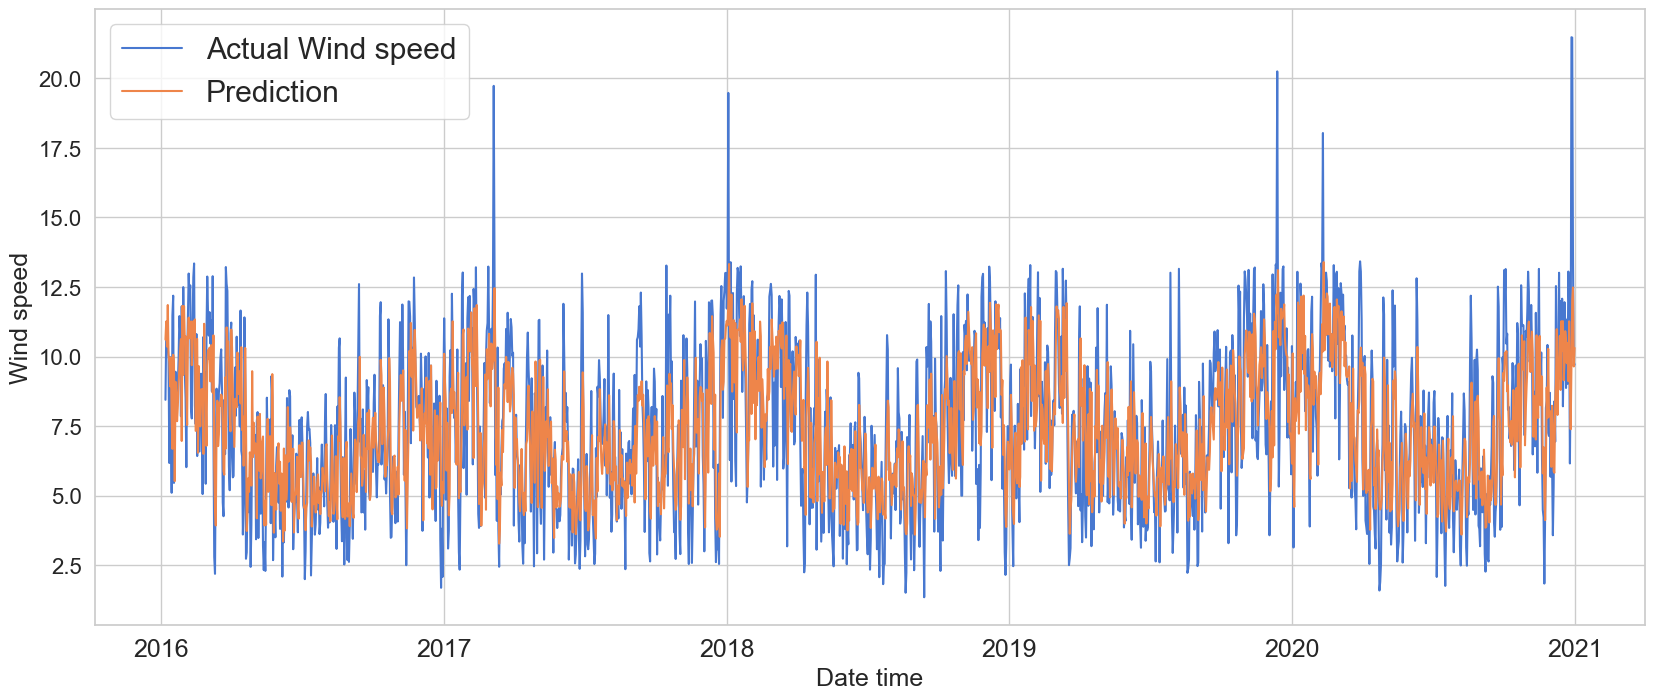

In [31]:
# Waind speed prediction
plt.figure(figsize=(20, 8))
plt.plot(df[7311:].index, df_prediction1['Wind speed Actuals'], label="Actual Wind speed")
plt.plot(df[7311:].index, df_prediction1['Wind speed Predictions'], label="Prediction")
plt.legend(loc='best', fontsize='large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel("Date time")
plt.ylabel("Wind speed")
plt.show()

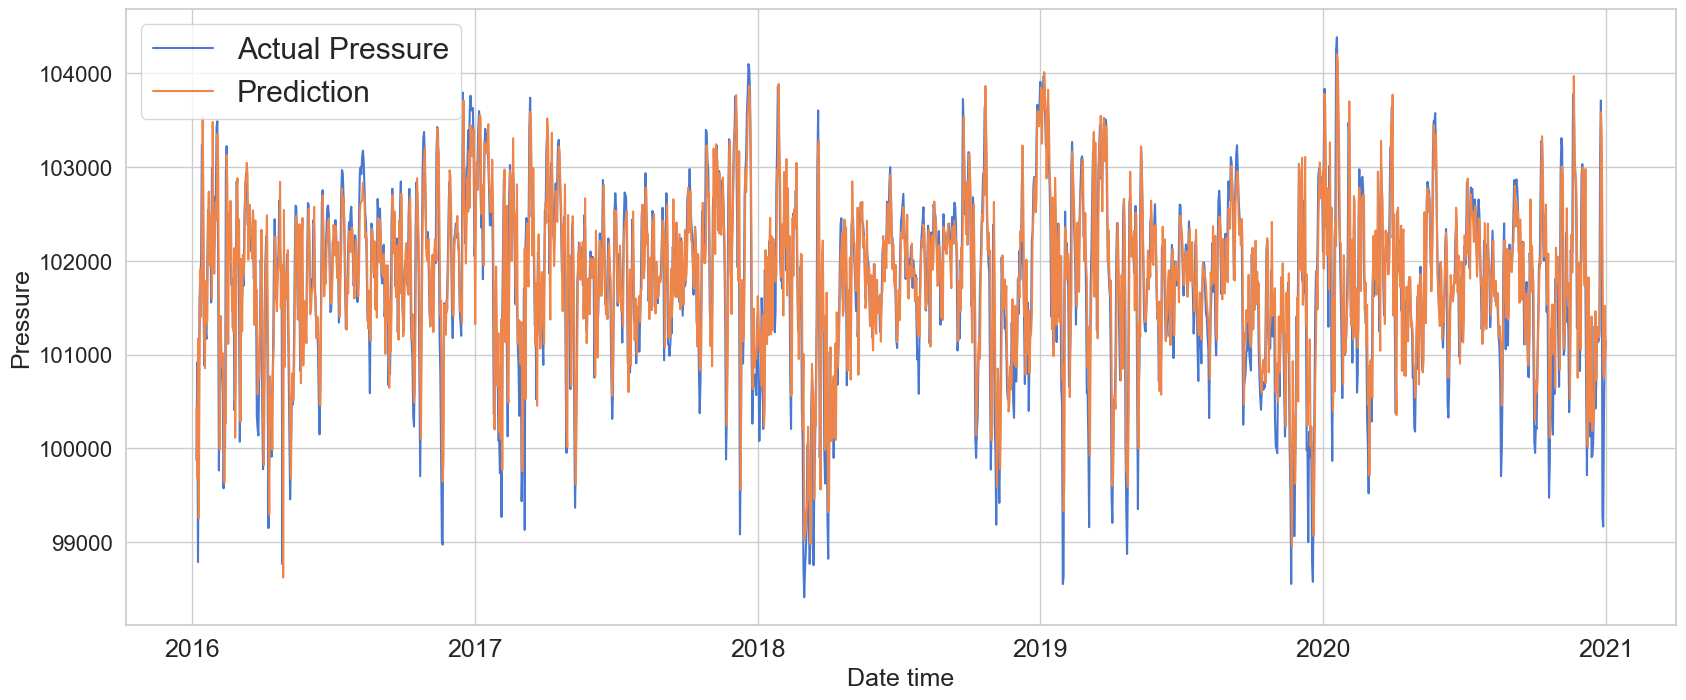

In [32]:
# Pressure prediction
plt.figure(figsize=(20, 8))
plt.plot(df[7311:].index, df_prediction1['Pressure Actuals'], label="Actual Pressure")
plt.plot(df[7311:].index, df_prediction1['Pressure Predictions'], label="Prediction")
plt.legend(loc='best', fontsize='large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel("Date time")
plt.ylabel("Pressure")
plt.show()

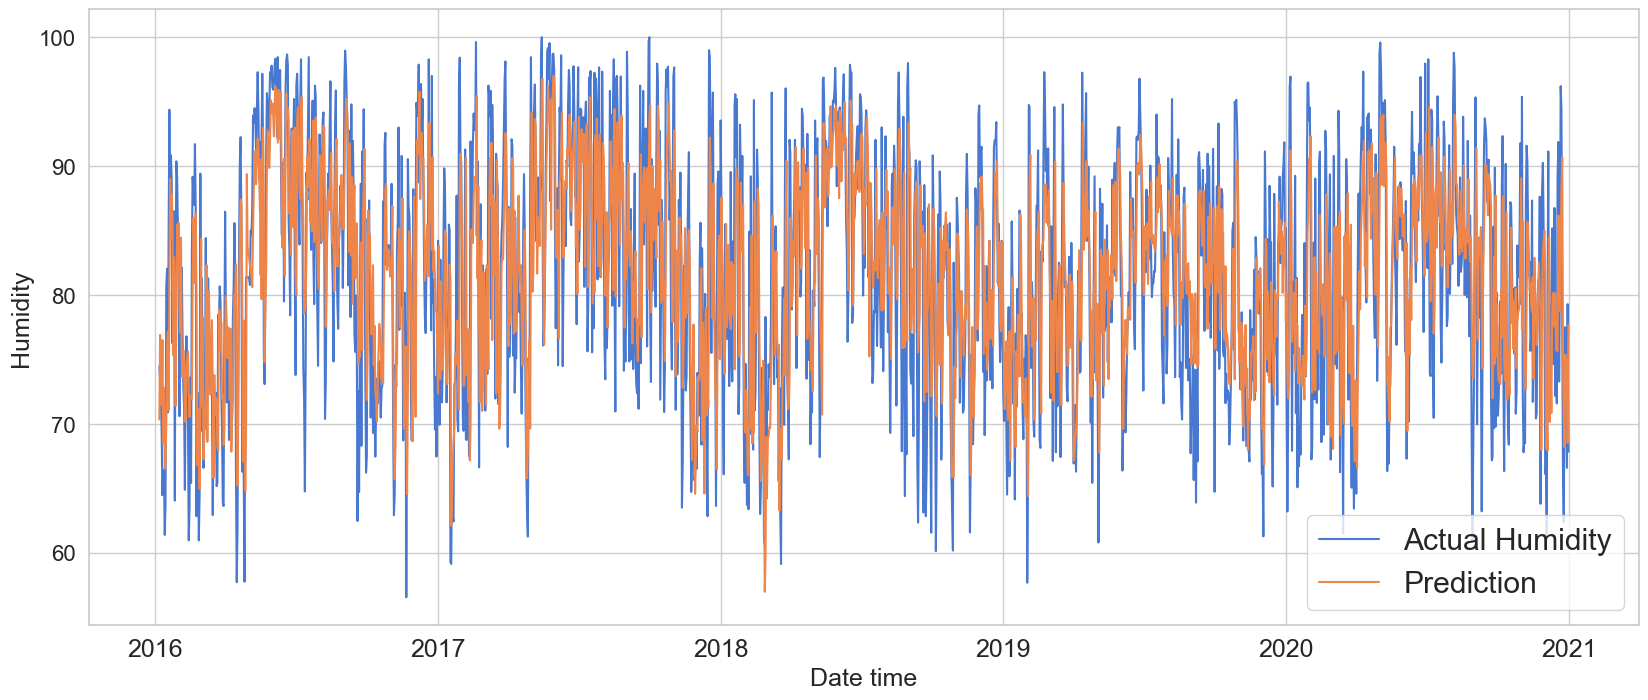

In [33]:
# Humidity prediction
plt.figure(figsize=(20, 8))
plt.plot(df[7311:].index, df_prediction1['Humidity Actuals'], label="Actual Humidity")
plt.plot(df[7311:].index, df_prediction1['Humidity Predictions'], label="Prediction")
plt.legend(loc='best', fontsize='large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel("Date time")
plt.ylabel("Humidity")
plt.show()

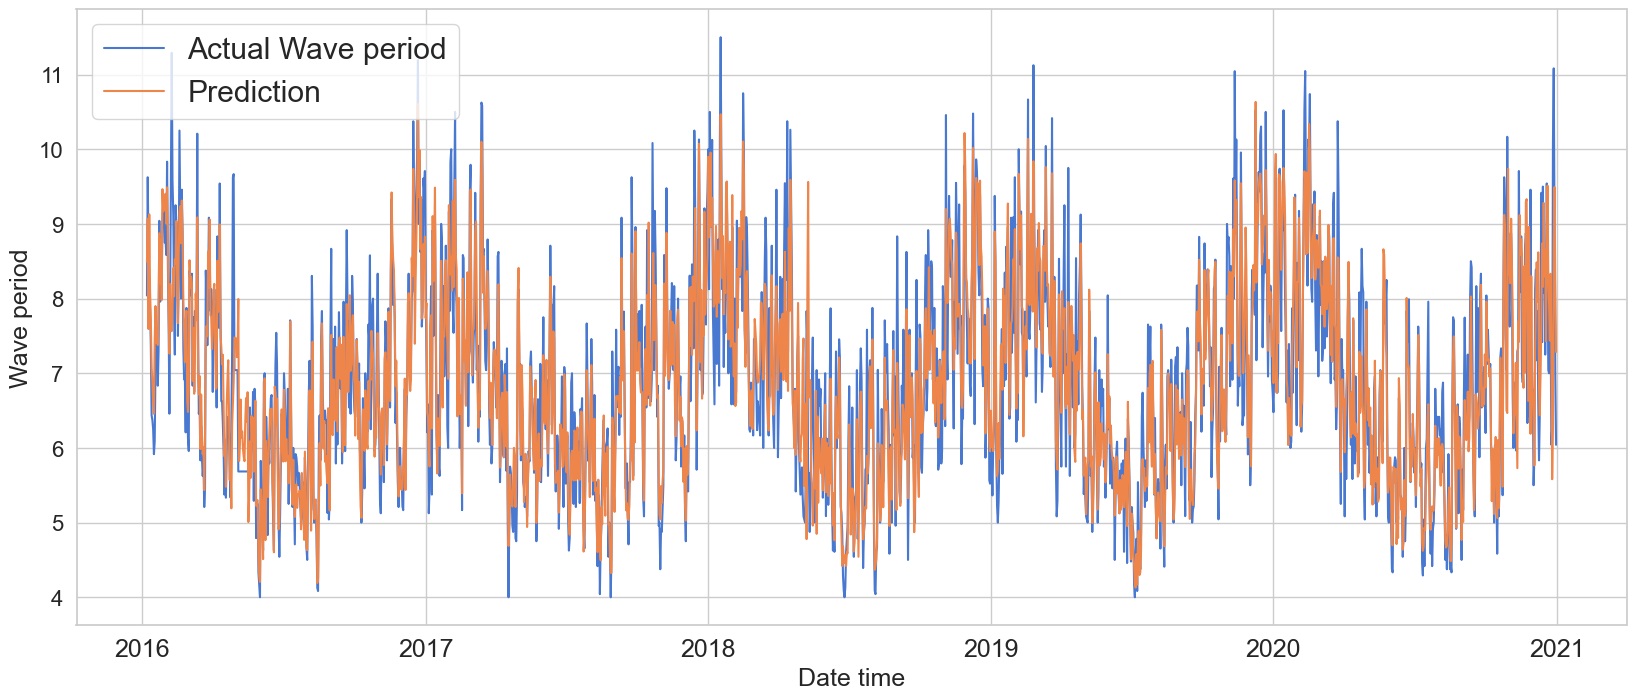

In [34]:
# Wave period prediction
plt.figure(figsize=(20, 8))
plt.plot(df[7311:].index, df_prediction1['Wave period Actuals'], label="Actual Wave period")
plt.plot(df[7311:].index, df_prediction1['Wave period Predictions'], label="Prediction")
plt.legend(loc='best', fontsize='large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.xlabel("Date time")
plt.ylabel("Wave period")
plt.show()

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

# Function to calculate Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate performance metrics
def calculate_metrics(y_true, y_pred, variable_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    correlation, p_value = stats.pearsonr(y_true, y_pred)

    print(f'{variable_name} Metrics:')
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')
    print(f'Mean Absolute Percentage Error: {mape:.2f}%')
    print(f'R2 Score (Coefficient of Determination): {r2:.4f}')
    print(f'Pearson Correlation Coefficient: {correlation:.4f}')
    print(f'P-value of Correlation Coefficient: {p_value:.4g}')
    print("\n")

# Extract the relevant columns
predicted_temperature = df_prediction1['Temperature Predictions']
actual_temperature = df_prediction1['Temperature Actuals']

predicted_humidity = df_prediction1['Humidity Predictions']
actual_humidity = df_prediction1['Humidity Actuals']

predicted_wind_speed = df_prediction1['Wind speed Predictions']
actual_wind_speed = df_prediction1['Wind speed Actuals']

predicted_pressure = df_prediction1['Pressure Predictions']
actual_pressure = df_prediction1['Pressure Actuals']

predicted_wave_height = df_prediction1['Wave height Predictions']
actual_wave_height = df_prediction1['Wave height Actuals']

predicted_period = df_prediction1['Wave period Predictions']
actual_period = df_prediction1['Wave period Actuals']

# Calculate metrics for temperature
calculate_metrics(actual_temperature, predicted_temperature, 'Temperature')

# Calculate metrics for Humidity
calculate_metrics(actual_humidity, predicted_humidity, 'Humidity')

# Calculate metrics for Wind speed
calculate_metrics(actual_wind_speed, predicted_wind_speed, 'Wind Speed')

# Calculate metrics for Pressure
calculate_metrics(actual_pressure, predicted_pressure, 'Pressure')

# Calculate metrics for Wave height
calculate_metrics(actual_wave_height, predicted_wave_height, 'Wave Height')

# Calculate metrics for Wave period
calculate_metrics(actual_period, predicted_period, 'Wave Period')

Temperature Metrics:
Mean Absolute Error: 0.6044
Mean Squared Error: 0.6595
Root Mean Squared Error: 0.8121
Mean Absolute Percentage Error: 0.21%
R2 Score (Coefficient of Determination): 0.9158
Pearson Correlation Coefficient: 0.9582
P-value of Correlation Coefficient: 0


Humidity Metrics:
Mean Absolute Error: 5.6622
Mean Squared Error: 50.8300
Root Mean Squared Error: 7.1295
Mean Absolute Percentage Error: 7.10%
R2 Score (Coefficient of Determination): 0.4080
Pearson Correlation Coefficient: 0.6490
P-value of Correlation Coefficient: 2.845e-218


Wind Speed Metrics:
Mean Absolute Error: 1.7707
Mean Squared Error: 5.0869
Root Mean Squared Error: 2.2554
Mean Absolute Percentage Error: 29.17%
R2 Score (Coefficient of Determination): 0.4083
Pearson Correlation Coefficient: 0.6447
P-value of Correlation Coefficient: 1.857e-214


Pressure Metrics:
Mean Absolute Error: 402.7259
Mean Squared Error: 309669.4443
Root Mean Squared Error: 556.4795
Mean Absolute Percentage Error: 0.40%
R2 Score (